## Data encoding...
*Preparing cleaned data for analysis...*
    
#### Basis for Encoding Logic ####
*Feature Selection for the final song-lyric dataset was based on the research of the following publications...*

1. [Tufts Music Mood Classification](https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/) 
2. [DISAMBIGUATING MUSIC EMOTION USING SOFTWARE AGENTS](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.458.2901&rep=rep1&type=pdf)
3. [Machine Learning Approach to PersonalityType Prediction Based on the Myers–BriggsType Indicator](chrome-extension://abkfbakhjpmblaafnpgjppbmioombali/pdfjs/viewer.html?file=https://mdpi-res.com/d_attachment/mti/mti-04-00009/article_deploy/mti-04-00009-v2.pdf)
4. New sources to investigate:
    - [Super-Convenience for Non-musicians:
Querying MP3 and the Semantic Web](http://ismir2002.ircam.fr/proceedings/03-SP05-3.pdf)
    - [LNAI 2915 - Gesture-Based Communication in Human-Computer Interaction](https://link.springer.com/content/pdf/10.1007/b95740.pdf)
    - https://www.datadriveninvestor.com/2019/06/03/training-ai-to-predict-myers-briggs-personality-types-from-texts/#
    - MBTI labelled_data_source: [(MBTI) Myers-Briggs Personality Type Dataset](https://www.kaggle.com/datasets/datasnaek/mbti-type?resource=download)
- see useful example of this [here.]
5. [Great foundation for scaling variables; Guide to Scaling and Standardizing](https://www.kaggle.com/code/discdiver/guide-to-scaling-and-standardizing/notebook)

In [1]:
# imports...
import os
import ast
import math
import calendar
import warnings
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pylab as plt

from os import listdir
from datetime import datetime
from dotenv import load_dotenv
from os.path import isfile, join
from sklearn import preprocessing
from sklearn import preprocessing
from pandas.plotting import scatter_matrix, parallel_coordinates

# dev environment imports
import qgrid

warnings.filterwarnings("ignore")
%matplotlib inline
matplotlib.style.use("ggplot")
np.random.seed(34)

load_dotenv()

True

In [15]:
# initializing environment...
data_path = "/Users/dayoorigunwa/code_base/music_mapping/data/"
allfiles = [f for f in listdir(data_path) if isfile(join(data_path, f))]
prepped_dfs = [filename for filename in allfiles if "prepped_dataset" in filename]
prepped_dfs.sort()
song_df = pd.read_csv(data_path + prepped_dfs[-1])

# filtering bad data...
song_df = song_df[song_df["lyrics"].notna()]  # 1066 --> 647 :)
song_df = song_df.drop(columns=["Unnamed: 0"])

# setting types...
song_df.date_added = pd.to_datetime(
    song_df["date_added"], format="%Y-%m-%dT%H:%M:%S.%f"
)
song_df["utils_genius_data"] = song_df["utils_genius_data"].apply(
    lambda x: ast.literal_eval(x)
)

# variable defs...
audio_cols = [
    "energy",
    "liveness",
    "tempo",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "time_signature",
    "danceability",
    "valence",
    "duration_ms",
    "loudness",
]
audio_df = song_df.drop(
    columns=[col for col in list(song_df.columns) if col not in audio_cols]
)

# view df...
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 0 to 626
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy            625 non-null    float64
 1   liveness          625 non-null    float64
 2   tempo             625 non-null    float64
 3   speechiness       625 non-null    float64
 4   acousticness      625 non-null    float64
 5   instrumentalness  625 non-null    float64
 6   time_signature    625 non-null    float64
 7   danceability      625 non-null    float64
 8   valence           625 non-null    float64
 9   duration_ms       625 non-null    float64
 10  loudness          625 non-null    float64
dtypes: float64(11)
memory usage: 58.6 KB


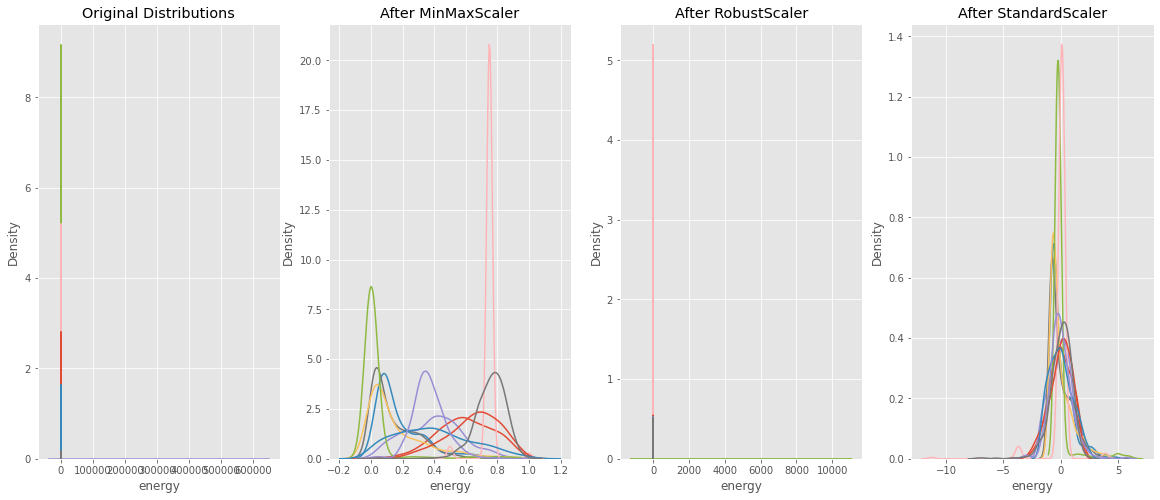

In [16]:
# Combined plot.
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20, 8))

ax0.set_title("Original Distributions")
for col in audio_cols:
    sns.kdeplot(audio_df[col], ax=ax0)

# MinMaxScaling...
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(audio_df)
df_mm = pd.DataFrame(df_mm, columns=list(audio_df.columns))

# Viewing results...
ax1.set_title("After MinMaxScaler")
for col in audio_cols:
    sns.kdeplot(df_mm[col], ax=ax1)

# Robust Scaling...
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(audio_df)
df_r = pd.DataFrame(df_r, columns=list(audio_df.columns))

# Viewing results...
ax2.set_title("After RobustScaler")
for col in audio_cols:
    sns.kdeplot(df_r[col], ax=ax2)

# Standard Scaling...
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(audio_df)
df_s = pd.DataFrame(df_s, columns=list(audio_df.columns))

# Viewing results...
ax3.set_title("After StandardScaler")
for col in audio_cols:
    sns.kdeplot(df_s[col], ax=ax3)

In [4]:
# from pandas_profiling import ProfileReport
# prof = ProfileReport(song_df)
# prof

In [17]:
# Scaling, standardizing & normalizing
mm_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = mm_scaler.fit_transform(X_train)

song_df["norm_duration_ms"] = song_df.duration_ms / song_df.duration_ms.max()
song_df["norm_loudness"] = song_df.loudness.abs() / song_df.loudness.abs().max()

for col in audio_cols:
    song_df["norm_" + col] = (song_df[col] - song_df[col].mean()) / song_df[col].std()

In [18]:
song_df.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,valence,duration_ms,...,norm_loudness,norm_energy,norm_liveness,norm_tempo,norm_speechiness,norm_acousticness,norm_instrumentalness,norm_time_signature,norm_danceability,norm_valence
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,...,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02,6.250000e+02
mean,0.640507,0.211974,121.804294,0.152948,0.165300,0.036423,3.974400,0.686394,0.407082,231270.737600,...,-3.410605e-16,-3.637979e-16,-5.400125e-17,-6.536993e-16,-2.273737e-17,2.273737e-17,6.821210e-17,-5.911716e-16,4.149570e-16,-1.818989e-16
std,0.146304,0.155053,26.473269,0.130268,0.197912,0.144114,0.264304,0.141830,0.224233,63782.365554,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.157000,0.038200,65.256000,0.024200,0.000014,0.000000,1.000000,0.143000,0.035200,15500.000000,...,-7.212032e+00,-3.304813e+00,-1.120742e+00,-2.136053e+00,-9.883269e-01,-8.351463e-01,-2.527346e-01,-1.125372e+01,-3.831303e+00,-1.658464e+00
25%,0.540000,0.107000,100.041000,0.049500,0.024600,0.000000,4.000000,0.596000,0.233000,194739.000000,...,-5.136442e-01,-6.869752e-01,-6.770222e-01,-8.220856e-01,-7.941126e-01,-7.109204e-01,-2.527346e-01,9.685830e-02,-6.373378e-01,-7.763438e-01
50%,0.642000,0.147000,122.482000,0.101000,0.081500,0.000000,4.000000,0.702000,0.389000,225020.000000,...,1.227344e-01,1.020341e-02,-4.190453e-01,2.559962e-02,-3.987752e-01,-4.234190e-01,-2.527346e-01,9.685830e-02,1.100360e-01,-8.063769e-02
75%,0.751000,0.280000,139.988000,0.231000,0.246000,0.000096,4.000000,0.791000,0.556000,264572.000000,...,6.404914e-01,7.552277e-01,4.387279e-01,6.868704e-01,5.991638e-01,4.077584e-01,-2.520691e-01,9.685830e-02,7.375479e-01,6.641247e-01
max,0.968000,0.970000,207.982000,0.916000,0.983000,0.942000,5.000000,0.977000,0.974000,596773.000000,...,2.339988e+00,2.238441e+00,4.888829e+00,3.255272e+00,5.857535e+00,4.131635e+00,6.283755e+00,3.880386e+00,2.048977e+00,2.528260e+00


[example code for df -> dict encoding...](https://stackoverflow.com/questions/26716616/convert-a-pandas-dataframe-to-a-dictionary)

In [24]:
# only applying tufts encodings for now...
# NOTE: This is a correlation matrix!!
tufts_codes = pd.read_csv(data_path + "tufts_music_moods.csv")
en_cols = list(tufts_codes.columns)
for col in en_cols:
    tufts_codes[col] = tufts_codes[col].astype("str")
tufts_codes

,Mood,Intensity,Timbre,Pitch,Rhythm
0,Happy,Medium,Medium,Very High,Very High
1,Exuberant,High,Medium,High,High
2,Energetic,Very High,Medium,Medium,High
3,Frantic,High,Very High,Low,Very High
4,Anxious/Sad,Medium,Very Low,Very Low,Low
5,Depression,Low,Low,Low,Low
6,Calm,Very Low,Very Low,Medium,Very Low
7,Contentment,Low,Low,High,Low


### Goal: Transforming Numerical Data into Categorical Data

#### Experimenting with bins...
*pd.cut vs. pd.qcut...*

In [19]:
df_mm.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,valence,duration_ms,loudness
count,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,0.596186,0.186493,0.396202,0.144369,0.168146,0.038665,0.743600,0.651551,0.396124,0.371204,0.755027
std,0.180399,0.166401,0.185483,0.146074,0.201338,0.152987,0.066076,0.170060,0.238850,0.109729,0.104690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.472256,0.073836,0.243719,0.028370,0.025011,0.000000,0.750000,0.543165,0.210695,0.308356,0.701254
50%,0.598027,0.116763,0.400950,0.086118,0.082896,0.000000,0.750000,0.670264,0.376864,0.360450,0.767876
75%,0.732429,0.259498,0.523605,0.231891,0.250243,0.000102,0.750000,0.776978,0.554751,0.428494,0.822080
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
df_mm.instrumentalness.describe()

count    625.000000
mean       0.038665
std        0.152987
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000102
max        1.000000
Name: instrumentalness, dtype: float64

In [8]:
# binning vars...
# bins_3 = [0, 1 / 3, 2 / 3, 1]
# bins_4 = [0, 1 / 4, 1 / 2, 3 / 4, 1]
bins_5 = [0, 1 / 5, 2 / 5, 3 / 5, 4 / 5, 1]

# bins_3_labels = ["1/3", "2/3", "3/3"]
# bins_4_labels = ["1/4", "2/4", "3/4", "4/4"]
bins_5_labels = ["Low", "Very Low", "Medium", "High", "Very High"]
bin_dict = {
    # 3: {"bins": bins_3, "labels": bins_3_labels},
    # 4: {"bins": bins_4, "labels": bins_4_labels},
    5: {"bins": bins_5, "labels": bins_5_labels},
}

In [9]:
# CUT; creating a column for each bin size...
for b in list(bin_dict.keys()):
    for col in audio_cols:
        col_label = col + "_b" + str(b) + "_label"
        results, bin_edges = pd.cut(
            song_df[col],
            bins=bin_dict[b]["bins"],
            labels=bin_dict[b]["labels"],
            retbins=True,
        )
        if results.isnull().sum() < 1:
            song_df[col_label] = results

song_df.head(5)

,name,artist,lyrics,date_added,energy,liveness,tempo,speechiness,acousticness,instrumentalness,...,speechiness_b4_label,acousticness_b4_label,danceability_b4_label,valence_b4_label,energy_b5_label,liveness_b5_label,speechiness_b5_label,acousticness_b5_label,danceability_b5_label,valence_b5_label
0,Then the Quiet Explosion,Hammock,I can’t feel you There’s no trace Lights will ...,2019-02-14 01:14:15+00:00,0.357,0.0827,95.663,0.0351,0.6520,0.894,...,1/4,3/4,1/4,1/4,2/5,1/5,1/5,4/5,1/5,1/5
2,Immunity,Jon Hopkins,You've answered my prayer For a worthless diam...,2019-11-03 13:41:48+00:00,0.305,0.1110,139.878,0.0364,0.8920,0.942,...,1/4,4/4,2/4,1/4,2/5,1/5,1/5,5/5,3/5,1/5
3,Mumma Don't Tell,Leifur James,My mama don't tell I'm the same My mama don't ...,2020-10-04 19:20:37+00:00,0.283,0.1100,108.028,0.0482,0.3450,0.762,...,1/4,2/4,4/4,1/4,2/5,1/5,1/5,2/5,5/5,1/5
4,Quick Musical Doodles,Two Feet,You remember You remember my love You sold yo...,2020-10-04 19:23:11+00:00,0.349,0.3740,169.773,0.2700,0.2410,0.685,...,2/4,1/4,3/4,2/4,2/5,2/5,2/5,2/5,4/5,3/5
6,Killing Me To Love You,Vancouver Sleep Clinic,Your body is broken but you’re trying to figh...,2020-10-04 19:25:53+00:00,0.567,0.1450,167.537,0.0327,0.0623,0.183,...,1/4,1/4,2/4,2/4,3/5,1/5,1/5,1/5,2/5,2/5


In [10]:
# qCUT; creating a column for each bin size...
for b in list(bin_dict.keys()):
    for col in audio_cols:
        col_label = col + "_q" + str(b) + "_label"
        try:
            results, bin_edges = pd.qcut(
                song_df[col],
                q=bin_dict[b]["bins"],
                labels=bin_dict[b]["labels"],
                retbins=True,
                duplicates="drop",
            )
        except:
            print(f"Failed on: {col_label}")
        if results.isnull().sum() < 1:
            song_df[col_label] = results

song_df.head(5)

Failed on: instrumentalness_q3_label
Failed on: time_signature_q3_label
Failed on: instrumentalness_q4_label
Failed on: time_signature_q4_label
Failed on: instrumentalness_q5_label
Failed on: time_signature_q5_label


,name,artist,lyrics,date_added,energy,liveness,tempo,speechiness,acousticness,instrumentalness,...,liveness_q5_label,tempo_q5_label,speechiness_q5_label,acousticness_q5_label,instrumentalness_q5_label,time_signature_q5_label,danceability_q5_label,valence_q5_label,duration_ms_q5_label,loudness_q5_label
0,Then the Quiet Explosion,Hammock,I can’t feel you There’s no trace Lights will ...,2019-02-14 01:14:15+00:00,0.357,0.0827,95.663,0.0351,0.6520,0.894,...,1/5,1/5,1/5,5/5,5/5,5/5,1/5,1/5,5/5,1/5
2,Immunity,Jon Hopkins,You've answered my prayer For a worthless diam...,2019-11-03 13:41:48+00:00,0.305,0.1110,139.878,0.0364,0.8920,0.942,...,2/5,4/5,1/5,5/5,5/5,5/5,1/5,1/5,5/5,1/5
3,Mumma Don't Tell,Leifur James,My mama don't tell I'm the same My mama don't ...,2020-10-04 19:20:37+00:00,0.283,0.1100,108.028,0.0482,0.3450,0.762,...,2/5,2/5,2/5,5/5,5/5,5/5,5/5,1/5,5/5,1/5
4,Quick Musical Doodles,Two Feet,You remember You remember my love You sold yo...,2020-10-04 19:23:11+00:00,0.349,0.3740,169.773,0.2700,0.2410,0.685,...,5/5,5/5,5/5,4/5,4/5,4/5,3/5,3/5,1/5,2/5
6,Killing Me To Love You,Vancouver Sleep Clinic,Your body is broken but you’re trying to figh...,2020-10-04 19:25:53+00:00,0.567,0.1450,167.537,0.0327,0.0623,0.183,...,3/5,5/5,1/5,3/5,3/5,3/5,1/5,2/5,2/5,1/5


In [11]:
# saving this checkpoint for now...
date_piece = datetime.today().strftime("%Y-%m-%d")
song_df.to_csv(data_path + "encoded_dataset_" + date_piece + ".csv")

### Applying mood mappings...

In [11]:
# NOTE: map_mood doesn't exist at the moment...
# song_df['moods_eq'] = song_df.apply(lambda x: map_mood(x), axis=1)

In [25]:
# # Encoding with numbers for the moment...
mood_map = dict(zip(list(tufts_codes.Mood.values),list()))
for col in en_cols:
    tufts_codes[col] = tufts_codes[col].map(mood_map).fillna(tufts_codes[col])
tufts_codes

,Mood,Intensity,Timbre,Pitch,Rhythm
0,Happy,Medium,Medium,Very High,Very High
1,Exuberant,High,Medium,High,High
2,Energetic,Very High,Medium,Medium,High
3,Frantic,High,Very High,Low,Very High
4,Anxious/Sad,Medium,Very Low,Very Low,Low
5,Depression,Low,Low,Low,Low
6,Calm,Very Low,Very Low,Medium,Very Low
7,Contentment,Low,Low,High,Low


In [13]:
# TODO: identify reliable way of mapping existing spotify features into the listed fields...
#
# Spotify Feautures:
"""
    energy
    liveness
    tempo
    speechiness
    acousticness
    instrumentalness
    time_signature
    danceability
    duration_ms
    loudness (INTENSITY)
    valence
"""

# Join Keys
"""
    song_name
    song_artist
    song_lyrics
    date_added
    Utils for data_mapping
    utils_spotify_id
    utils_genius_data
"""

# Mood Encodings
"""
    Intensity (LOUDNESS)
        - done
    Timbre 
        - timbre can also be retrieved from the audio-analysis endpoint. The data will probalby have to be adjusted before the mean is calculated, since the spotify data contains negative values but the study does not seem to.
    Pitch (overall frequency)
        - can be retrieved from the audio-analysis endpoint; just stick to mean values to start, that is what the Tufts study relied on
    Rhythm (~danceability)
        - 
"""

# Mappings
"""
 The tufts encodings used in this project were produced by researchers via a correlation table of intensity, timbre, pitch, and rhythm in identifying various moods.

 Sound sources that have simple harmonic profiles have ‘darker’ timbres and tend to soothe human emotions”
 Higher overall pitch can be an indicator of happiness, carefree and light moods within a song, while lower pitch implies a darker, sad, and serious tone.
 Faster tempos are associated with high-energy songs, and slower tempos with lower energy, sadder songs. 
 Timbre, the tonal component of a piece created by harmonics, is a curious indicator of mood. According to a group of researchers from the BNM Institute of Technology in Bangalore, India, “timbre stimulates human energy levels without regard to rhythmic or harmonic saturation.
 Loudness, or intensity of a song can be connected with anger, while softer songs would suggest tenderness, sadness, or fear
"""

# Notes from: A Survey on Visualizations of Musical Data
"""
The pitch is quantified by a frequency, describing the physical phenomenon of oscillation of sound waves. It gains a musical dimension through the relation to other frequencies in a complete range of sounds. Thus, it is the feature that defines the height po- sition in a musical score notation. Examination of it is interesting, especially for comparison between today’s and music of the past, as the concert pitches of instruments have changed throughout the centuries.
• A musical note is a symbolization of a musical sound encoding pitch and duration of it. In order to define the position of a musical note in a score, we refer to scientific pitch notation which is a method for the explicit description of a pitch using its note name and octave number.
• The musical score is the notated version of a musical piece. It consists of multiple notes, varying according to its system and media, like written sheet music or digital MIDI. It encodes the musical features for storage, exchange or replay. One example of a classical sheet notation is visible in Figure 2 (top), where the notes are complemented by additional information such as tempo or repetition for its performance.
• The key of a musical piece is the root (tonic note) in which it is composed. This note and its corresponding chords form the tonal- ity of the piece.
• The dynamic describes the variability of loudness within a musical piece.
• Timbre is the perceived sound quality of a soundarisingfromthe mixture of different frequencies by overlapping of the fundamen- tal tone and partial tones. It describes the tone colour of individual instruments or voices even if they are equally tuned.
• Music is described by its features that can be divided into low level features, physical attributes like pitch, tempo or loudness, perceived high level features, for example, timbre and structural features such as dynamics and repeating motifs.
"""

'\nThe pitch is quantified by a frequency, describing the physical phenomenon of oscillation of sound waves. It gains a musical di- mension through the relation to other frequencies in a complete range of sounds. Thus, it is the feature that defines the height po- sition in a musical score notation. Examination of it is interesting, especially for comparison between today’s and music of the past, as the concert pitches of instruments have changed throughout the centuries.\n• A musical note is a symbolization of a musical sound encoding pitch and duration of it. In order to define the position of a musical note in a score, we refer to scientific pitch notation which is a method for the explicit description of a pitch using its note name and octave number.\n• The musical score is the notated version of a musical piece. It consists of multiple notes, varying according to its system and media, like written sheet music or digital MIDI. It encodes the musical features for storage, exchange o

In [14]:
# sanity check
song_df.head()

,name,artist,lyrics,date_added,energy,liveness,tempo,speechiness,acousticness,instrumentalness,...,liveness_b4_label,tempo_b4_label,speechiness_b4_label,acousticness_b4_label,instrumentalness_b4_label,time_signature_b4_label,danceability_b4_label,valence_b4_label,duration_ms_b4_label,loudness_b4_label
0,Then the Quiet Explosion,Hammock,I can’t feel you There’s no trace Lights will ...,2019-02-14 01:14:15+00:00,0.357,0.0827,95.663,0.0351,0.6520,0.894,...,lowest,NaN,lowest,high,highest,NaN,lowest,lowest,NaN,NaN
2,Immunity,Jon Hopkins,You've answered my prayer For a worthless diam...,2019-11-03 13:41:48+00:00,0.305,0.1110,139.878,0.0364,0.8920,0.942,...,lowest,NaN,lowest,highest,highest,NaN,low,lowest,NaN,NaN
3,Mumma Don't Tell,Leifur James,My mama don't tell I'm the same My mama don't ...,2020-10-04 19:20:37+00:00,0.283,0.1100,108.028,0.0482,0.3450,0.762,...,lowest,NaN,lowest,low,highest,NaN,highest,lowest,NaN,NaN
4,Quick Musical Doodles,Two Feet,You remember You remember my love You sold yo...,2020-10-04 19:23:11+00:00,0.349,0.3740,169.773,0.2700,0.2410,0.685,...,low,NaN,low,lowest,high,NaN,high,low,NaN,NaN
6,Killing Me To Love You,Vancouver Sleep Clinic,Your body is broken but you’re trying to figh...,2020-10-04 19:25:53+00:00,0.567,0.1450,167.537,0.0327,0.0623,0.183,...,lowest,NaN,lowest,lowest,lowest,NaN,low,low,NaN,NaN


In [15]:
# sanity check
song_df.columns

Index(['name', 'artist', 'lyrics', 'date_added', 'energy', 'liveness', 'tempo',
       'speechiness', 'acousticness', 'instrumentalness', 'time_signature',
       'danceability', 'valence', 'duration_ms', 'loudness',
       'utils_spotify_id', 'utils_genius_data', 'flavor_text_idx',
       'flavor_text', 'basic_clean', 'clean_tokes', 'stemmed', 'lemmatized',
       'pos_tags', 'clean_lemmatized', 'song_length', 'norm_energy',
       'norm_liveness', 'norm_tempo', 'norm_speechiness', 'norm_acousticness',
       'norm_instrumentalness', 'norm_time_signature', 'norm_danceability',
       'norm_valence', 'norm_duration_ms', 'norm_loudness', 'energy_b3_label',
       'liveness_b3_label', 'tempo_b3_label', 'speechiness_b3_label',
       'acousticness_b3_label', 'instrumentalness_b3_label',
       'time_signature_b3_label', 'danceability_b3_label', 'valence_b3_label',
       'duration_ms_b3_label', 'loudness_b3_label', 'energy_b4_label',
       'liveness_b4_label', 'tempo_b4_label', 'speechin

In [17]:
# ENCODING #

In [ ]:
## scratch work ##

In [8]:
# Data Discovery Tools...
song_df.isna().sum()

name                 0
artist               0
lyrics               0
date_added           0
energy               0
liveness             0
tempo                0
speechiness          0
acousticness         0
instrumentalness     0
time_signature       0
danceability         0
valence              0
duration_ms          0
loudness             0
utils_spotify_id     0
utils_genius_data    0
flavor_text_idx      0
flavor_text          0
basic_clean          0
clean_tokes          0
stemmed              1
lemmatized           1
pos_tags             0
clean_lemmatized     1
song_length          0
dtype: int64